In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xtrack as xt
import xcoll as xc
import xpart as xp
import xobjects as xo

In [2]:
def remove_offmom_bpms_apers(line, exn=3.5e-6, nrj=21, pmass=0.938, bucket_height=3e-3, n_buckets=2):
    "Remove apertures of off-momentum BPMs which give flanges as bottlenecks"
    tt = line.get_table()
    tw = line.twiss()
    mask_disp = 5*np.sqrt(tw.betx*exn*pmass/nrj)+n_buckets*bucket_height*tw.dx > 0.025
    mask_bpm = ['bp' in name for name in tt.name]
    mask_aper = np.array(['aper' in name for name in tt.name])
    offmom_bpms = tt.name[mask_disp & mask_bpm & ~mask_aper]
    aper_to_remove = [f'{name}{suffix}' for name in offmom_bpms for suffix in ('.a_aper', '.b_aper')]
    line.remove(aper_to_remove)

def install_tidp(line, block_mvt=29e-3):
    tidp_ap_tot = 147e-3
    line.discard_tracker()
    tidp = xc.EverestCollimator(length=4.3, material=xc.materials.Carbon, jaw_L= tidp_ap_tot/2 + block_mvt, jaw_R = -tidp_ap_tot/2 + block_mvt)
    line.collimators.install(names=['tidp.11434'], elements=[tidp])
    return tidp

def install_tcsm(line):
    tcsm = xc.EverestCollimator(length=1.83, gap=5, material=xc.materials.Carbon) # length is 1.83
    line.collimators.install(names=['tcsm.51932'], elements=[tcsm])
    return tcsm

In [13]:
num_particles = 1000
num_turns = 3000
plane = 'H'
amplitude_adt = 0.07
start_at_turn=1000
nemitt_x = 2e-6
nemitt_y = 2e-6

In [14]:
line = xt.Line.from_json('../../injection_lines/sps_with_aperture_inj_q20_beam_sagitta4.json')

env = line.env
#crab cavities: acfcah.61738 and acfcah.61739
crab1 = xt.CrabCavity(crab_voltage=0, frequency = line['actcse.31632'].frequency, lag=0)
crab2 = xt.CrabCavity(crab_voltage=0, frequency = line['actcse.31632'].frequency, lag=0)
env.elements['acfcah.61738'] = crab1
env.elements['acfcah.61739'] = crab2
tt = line.get_table()

remove_offmom_bpms_apers(line, exn=3.5e-6, nrj=21, pmass=0.938, bucket_height=3e-3, n_buckets=2)
tidp = install_tidp(line, block_mvt=29e-3)
tcsm = install_tcsm(line)

Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           


Slicing line:   0%|          | 0/32246 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/32246 [00:00<?, ?it/s]

In [15]:
adt = xc.BlowUp.install(line, name=f'adt_{plane}_blowup', at_s=line.get_s_position('adkcv.32171'), plane=plane, stop_at_turn=num_turns,
                        amplitude=amplitude_adt, use_individual_kicks=False, start_at_turn=start_at_turn)

tw = line.twiss()
line.collimators.assign_optics(twiss=tw, nemitt_x=nemitt_x, nemitt_y=nemitt_y)

In [16]:
part = xp.generate_matched_gaussian_bunch(nemitt_x=nemitt_x,
                                          nemitt_y=nemitt_y,
                                          sigma_z=0.224, num_particles=num_particles, line=line)

*** Maximum RMS bunch length 0.2333663781336932m.
... distance to target bunch length: -2.2228e-01
... distance to target bunch length: 4.5424e-03
... distance to target bunch length: 4.3382e-03
... distance to target bunch length: -6.6565e-03
... distance to target bunch length: 2.0203e-03
... distance to target bunch length: -5.7185e-04
... distance to target bunch length: 1.0779e-04
... distance to target bunch length: 4.7891e-06
... distance to target bunch length: -2.0504e-09
... distance to target bunch length: 9.6490e-08
--> Bunch length: 0.22399999794961262
--> Emittance: 0.34347649813344366


In [17]:
adt.calibrate_by_emittance(nemitt=nemitt_x, twiss=tw)

In [18]:
line.discard_tracker()
line.build_tracker(_context=xo.ContextCpu(omp_num_threads='auto'))

line.scattering.enable()
line.track(part, num_turns=500, time=True, with_progress=1)
line.scattering.disable()

Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/500 [00:00<?, ?it/s]

In [19]:
line['acfcah.61738'].crab_voltage = 1e6
line['acfcah.61739'].crab_voltage = 1e6

line.scattering.enable()
adt.activate()
line.track(part, num_turns=num_turns-500, time=True, with_progress=1)
adt.deactivate()
line.scattering.disable()
print(f"Done tracking in {line.time_last_track:.1f}s.")

Tracking:   0%|          | 0/2500 [00:00<?, ?it/s]

Done tracking in 162.4s.


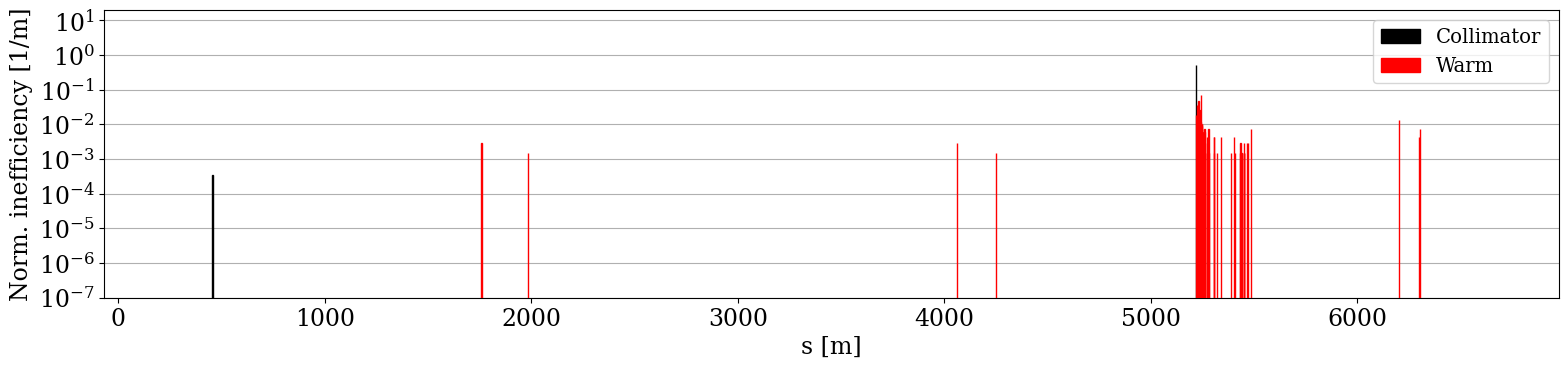

(<Figure size 1600x400 with 1 Axes>,
 <Axes: xlabel='s [m]', ylabel='Norm. inefficiency [1/m]'>)

In [20]:
ThisLM = xc.LossMap(line = line, line_is_reversed=False, part=part, interpolation=False)
ThisLM.plot()

In [21]:
np.unique(part.at_turn, return_counts=True)

(array([ 504,  505,  506,  507,  508,  511,  512,  513,  514,  515,  517,
         519,  521,  522,  523,  527,  530,  531,  532,  533,  535,  539,
         542,  543,  544,  551,  554,  560,  561,  563,  568,  572,  581,
         582,  589,  597,  598,  611,  619,  648,  732,  747,  750,  773,
         925,  996, 1007, 1008, 1010, 1013, 1014, 1018, 1020, 1021, 1022,
        1025, 1026, 1027, 1029, 1030, 1031, 1032, 1033, 1034, 1036, 1038,
        1042, 1043, 1046, 1047, 1050, 1051, 1053, 1054, 1055, 1056, 1057,
        1059, 1060, 1061, 1064, 1065, 1067, 1068, 1072, 1073, 1074, 1077,
        1078, 1080, 1081, 1082, 1084, 1085, 1087, 1088, 1089, 1090, 1091,
        1094, 1095, 1098, 1105, 1106, 1107, 1113, 1114, 1116, 1117, 1118,
        1121, 1122, 1125, 1137, 1138, 1185, 1206, 1208, 1210, 1214, 1215,
        1216, 1217, 1219, 1222, 1224, 1231, 1235, 1236, 1248, 1249, 1251,
        1252, 1253, 1254, 1256, 1257, 1258, 1261, 1262, 1265, 1266, 1267,
        1269, 1270, 1271, 1273, 1274, 

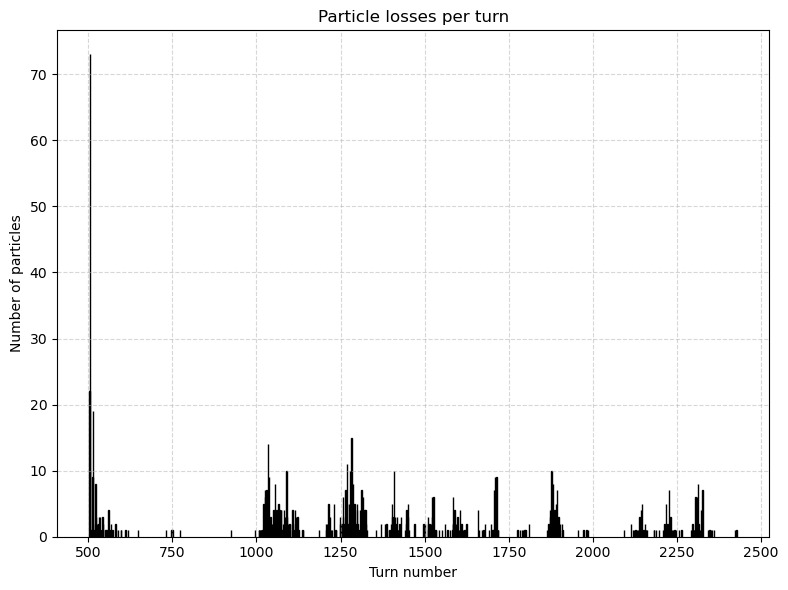

In [23]:
plt.close('all')
mask = part.state > 0
unique_turns, counts = np.unique(part.at_turn[~mask], return_counts=True)

fig, ax = plt.subplots(figsize=(8, 6))
# Plot histogram-like bar chart
ax.bar(unique_turns, counts, width=1.0, edgecolor='black')
ax.set_xlabel("Turn number")
ax.set_ylabel("Number of particles")
ax.set_title("Particle losses per turn")
ax.grid(True, linestyle='--', alpha=0.5)
fig.tight_layout()
plt.savefig('cavities_after_500_blowup_1500.png', dpi=300)
plt.show()